In [4]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

## Опрос в начале лекции
https://docs.google.com/forms/d/e/1FAIpQLSda7O_EcibA0-id7hpTDRZ6Lhom6IeQjcBtJEyAZEc-PKgw6A/viewform?usp=sf_link

## План лекции
- bias-variance tradeoff
- композиции алгоритмов (in general)
- bootstrap
- bagging
- RSM (random subsampling method)
- RandomForest
  * алгоритм
  * oob
  * важности признаков
- Boosting
  * adaboost
- Blending, stacking

## Bias variance tradeoff

https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Bias-variance-Tradeoff.php

https://en.wikipedia.org/wiki/Bias–variance_tradeoff

$Bias[f'(x)] = E[f'(x) - f(x)]$<br>
$Var[f'(x)] = E[f'(x)^2] - (E[f'(x)])^2$<br>


$E[(f(x) - f'(x))^2] = (Bias[f'(x)])^2 + Var[f'(x)] + \sigma^2$

Вывод формулы

$$E[(y - f')^2] = E[y^2 + f'^2 - 2 y f'] = E[y^2] + E[f'^2] - E[2yf'] = Var[y] + E[y]^2 + Var[f'] + E[f]^2 - 2fE[f'] = Var[y] + Var[f'] + (f - E[f'])^2 $$

# Ансамбли моделей


### Мудрость толпы

Если спросить много людей о некоторой характеристике и усреднить - получится результат лучше, чем полученный от одного эксперта.  

В онлайне размещена картинка с коровой. Люди заходят на сайт и дают оценку ее веса. Средний результат из 17000 предсказаний отклоняется от действительного значения на 5%.

https://en.wikipedia.org/wiki/Wisdom_of_the_crowd

https://www.amazon.com/Wisdom-Crowds-James-Surowiecki/dp/0385721706

### Теорема Кондорсе «о жюри присяжных»

https://ru.wikipedia.org/wiki/Парадокс_Кондорсе

### Netflix prize

Объявлен приз в 1 млн. долларов за улучшение предсказания на 10%. После построения простых качественных моделей составляются ансамбли из моделей. Это комбинирование простых моделей в одну более сложную, делающую более качественное предсказание.

https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf

## Voting Classifiers

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

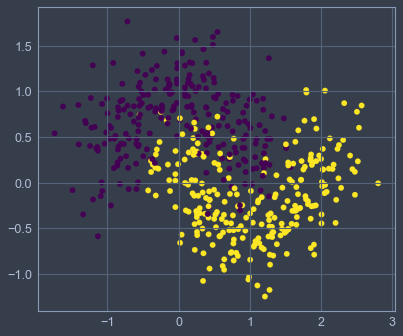

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Hard voting
Построим несколько простых моделей на одних и тех же данных.  
Предсказание будем делать всеми моделями, в результате предсказания выберем тот класс, за который проголосовало большинство моделей - **hard voting**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silen

### Soft voting
Если все классификаторы могут вернуть вероятность (реализован метод predict proba), то можем посчитать среднее - **soft voting**

In [9]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silen

In [11]:
voting_clf.predict_proba(X_test)

array([[0.55611089, 0.44388911],
       [0.80333358, 0.19666642],
       [0.65955121, 0.34044879],
       [0.01814628, 0.98185372],
       [0.05134482, 0.94865518],
       [0.15924051, 0.84075949],
       [0.9867671 , 0.0132329 ],
       [0.98152668, 0.01847332],
       [0.67056686, 0.32943314],
       [0.97606993, 0.02393007],
       [0.01518898, 0.98481102],
       [0.98586598, 0.01413402],
       [0.06419684, 0.93580316],
       [0.19269823, 0.80730177],
       [0.0758089 , 0.9241911 ],
       [0.92570277, 0.07429723],
       [0.97786368, 0.02213632],
       [0.05877976, 0.94122024],
       [0.20202757, 0.79797243],
       [0.93547522, 0.06452478],
       [0.95414873, 0.04585127],
       [0.15762376, 0.84237624],
       [0.43418963, 0.56581037],
       [0.80736295, 0.19263705],
       [0.93426248, 0.06573752],
       [0.81541138, 0.18458862],
       [0.18637412, 0.81362588],
       [0.9866982 , 0.0133018 ],
       [0.0206927 , 0.9793073 ],
       [0.98388717, 0.01611283],
       [0.

На ирисах:

In [12]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.900 (+/- 0.05) [Logistic Regression]
Accuracy: 0.933 (+/- 0.05) [Random Forest]
Accuracy: 0.913 (+/- 0.04) [naive Bayes]
Accuracy: 0.947 (+/- 0.05) [Ensemble]


/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandrbagdasa

In [13]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1, 1, 1])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
eclf = eclf.fit(X,y)


for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrb

Accuracy: 0.947 (+/- 0.03) [Logistic Regression]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.947 (+/- 0.03) [naive Bayes]
Accuracy: 0.947 (+/- 0.03) [Ensemble]


/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Подбор параметров

In [14]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandrbagdasa

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandrbagdasa

In [15]:
grid.best_estimator_

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                              

## Bootstrap

$N$ раз выбираем элементы с повторением из выборки. Сгенерируем $M$ подвыборок $X_1, X_2,...,X_m$. По каждой из данных выборок мы можем оценивать различные статистики.

(array([ 2.,  2.,  7., 10., 10., 15., 35., 64., 50., 31., 21., 19.,  7.,
         9.,  4.,  2.,  4.,  2.,  1.,  1.,  0.,  1.,  1.,  1.,  1.]),
 array([-2.02755378, -1.71570177, -1.40384977, -1.09199777, -0.78014577,
        -0.46829376, -0.15644176,  0.15541024,  0.46726224,  0.77911425,
         1.09096625,  1.40281825,  1.71467025,  2.02652226,  2.33837426,
         2.65022626,  2.96207826,  3.27393027,  3.58578227,  3.89763427,
         4.20948627,  4.52133828,  4.83319028,  5.14504228,  5.45689428,
         5.76874629]),
 <a list of 1 Patch objects>)

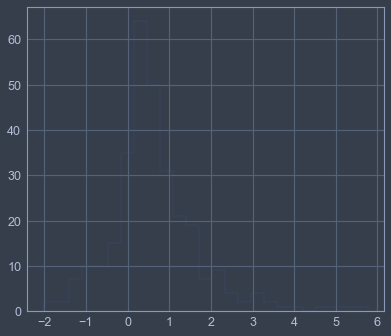

In [16]:
# For example, what is the 95% confidence interval for
# the mean of this data set

x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step')

In [17]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps))
mb = xb.mean(axis=0)
mb.sort()

np.percentile(mb, [2.5, 97.5])

array([0.53904985, 0.78071143])

# Bagging - bootstrap aggregation

Из выборки генерируем сэмпл. Сэмплирование делаем с возвращением.

In [18]:
def subsample(data, ratio=1.0):
    return np.random.choice(data, size=int(data.shape[0] * ratio), replace=True)

In [19]:
dataset = np.random.randint(0, 1000, size=1000)

In [20]:
dataset

array([987, 550,  88, 938,   4, 147, 872, 412,   7, 128, 437, 441, 994,
       684, 113, 883, 188, 462, 411, 330, 842, 781, 187, 133, 749, 894,
         7, 376, 337, 918, 630, 656, 958, 744, 675, 819, 122, 673, 279,
       297, 255, 606, 583, 478, 597, 642, 457, 721, 488, 980, 373, 241,
       737, 284, 692, 427,  41, 318, 360, 198, 150, 626, 636, 972, 619,
        89,  27, 104, 527, 686, 523, 302, 644, 535, 221, 961, 623, 481,
       140, 599, 750,  98, 426, 788,  86, 975, 492, 948, 925, 770, 824,
       401, 703, 901, 588, 804, 964, 530, 578,  36, 820, 266, 850, 769,
       451, 921, 760, 777, 678, 369,  31, 159, 793, 208, 869, 575, 243,
       547, 657, 619, 477, 727, 344, 578, 636, 197, 976, 250, 685, 749,
       580, 979, 134, 610,  56, 438, 462, 395, 577, 156, 866, 403, 118,
       583, 156, 821, 550,  96,  63, 800, 150, 349, 516, 267, 468, 887,
       549, 393, 997,  23, 249, 698, 421, 794, 309, 248, 548,  92, 171,
       592, 697, 856, 206, 395, 503, 536, 748, 195, 545, 485,  6

In [21]:
np.unique(np.bincount(dataset))

array([0, 1, 2, 3, 4, 5, 6])

In [22]:
sample = subsample(dataset, ratio=0.4)

In [23]:
print(sample)

[478 309 934 619 462 150  14 118  78 727  31 683 815 163 579 612 360  75
 527 476 507 248 874 856 562 360 336 840 426 788 284 781 408 947 337 697
 430  93  83 428 817 965 918  24  65 672 615 627  31 807  65 224 756 820
 985 891 474 695  13 747 945 660 436  80 874  63 893 538 248 659 527 196
 884  41 852 535 381 877 478 249 856 897 482 840 777 902 182 794 653 311
 639 371 311  12 525 627 284 642 418 188 966 488 444 473 527 673 600 437
 244 292 371 557 598 879 516 237 896 516 945 279 357 118  34 706 208 369
 373 156  92 308  34 612 226 237 921 668 718 781 625 366 485 858 441 684
  98 883 248 363 239 854 238 393 226 272 815 827 423 615 548 694 198 948
 184 942 891 749 675   6 580  24 183 756 901 119 672 800 360 309 939 232
 685 613 267 558 521 220 948 747 979 876 638 668 333  25 697 783   7 150
 559 345 250 182 133 219   6  78 429 211 349 237 318 256 698 771 311 716
 595 550  95 668 844 171 277 954 693 527 527 619 801 503 511 840 228 998
 479 724 522 936 232 733 363 187 282 966 382 516 79

In [24]:
print(np.unique(np.bincount(sample)))

[0 1 2 3 4 5 6]


In [25]:
sample

array([478, 309, 934, 619, 462, 150,  14, 118,  78, 727,  31, 683, 815,
       163, 579, 612, 360,  75, 527, 476, 507, 248, 874, 856, 562, 360,
       336, 840, 426, 788, 284, 781, 408, 947, 337, 697, 430,  93,  83,
       428, 817, 965, 918,  24,  65, 672, 615, 627,  31, 807,  65, 224,
       756, 820, 985, 891, 474, 695,  13, 747, 945, 660, 436,  80, 874,
        63, 893, 538, 248, 659, 527, 196, 884,  41, 852, 535, 381, 877,
       478, 249, 856, 897, 482, 840, 777, 902, 182, 794, 653, 311, 639,
       371, 311,  12, 525, 627, 284, 642, 418, 188, 966, 488, 444, 473,
       527, 673, 600, 437, 244, 292, 371, 557, 598, 879, 516, 237, 896,
       516, 945, 279, 357, 118,  34, 706, 208, 369, 373, 156,  92, 308,
        34, 612, 226, 237, 921, 668, 718, 781, 625, 366, 485, 858, 441,
       684,  98, 883, 248, 363, 239, 854, 238, 393, 226, 272, 815, 827,
       423, 615, 548, 694, 198, 948, 184, 942, 891, 749, 675,   6, 580,
        24, 183, 756, 901, 119, 672, 800, 360, 309, 939, 232, 68

In [26]:
means = []
n_iterations = 1000
for i in range(n_iterations):
    sample = subsample(dataset, ratio=0.4)
    mean = sample.mean()
    means.append(mean)
sum(means) / n_iterations

491.17621999999994

In [27]:
dataset.mean()

490.538

Основные идеи бэггинга:
* Сгенерировать подвыборку с возвращением, обучить модель.  
Для обучения будем использовать один и тот же алгоритм.  
* Повторить много раз
* Для нового примера сделать предсказание и сагрегировать результат (например, вычислить моду - самое частое или среднее предсказание)

Можно обучать параллельлно

### Упражнение (3 мин):
Какую компоненту ошибки уменьшает бэггинг?

http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


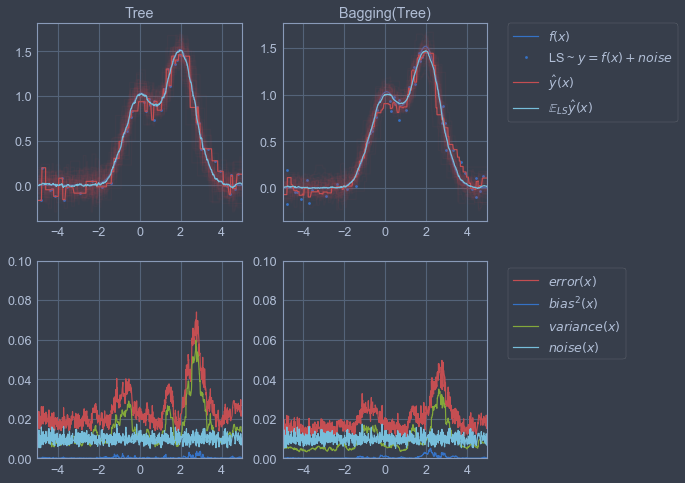

In [28]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

### Пример из scikit learn

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [31]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [32]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

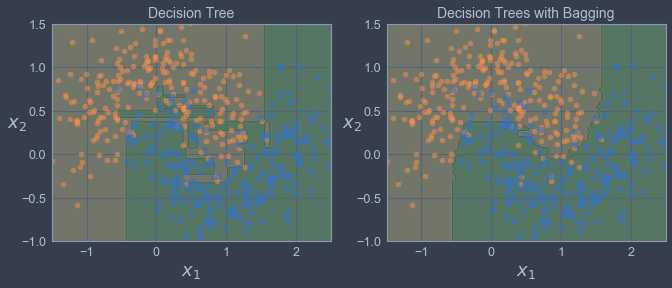

In [33]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Random subspace method

Идея: брать случайные признаки.

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|1   | 0.1  |10  |
|2  | 0.2  | 20 |
|3   |  0.3 | 30  |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|1   | 0.1  | 0.01  |
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |
|4   |  0.4 |  0.04 |

* bootstrap=False
* max_samples=1.0
* bootstrap_features=True
* max_features < 1.0

## Random Patches method

Брать случайные признаки и случайные примеры

* bootstrap=True
* max_samples= < 1.0
* bootstrap_features=True
* max_features < 1.0

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|2  | 0.2  | 20 |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |

## Random forest

1. $X_1, X_2, ..., X_N$ -- объекты выборки, $f_1, f_2, ..., f_M$ -- признаки
2. $n_{models}$ -- количество моделей в ансамбле
3. Для каждой модели выбираем количество признаков $m \le M$
4. Для каждой из моделей бутстрэпим выборку и обучаем модель на ней
5. Результатом работы случайного леса будет усредненное значение результатов отдельных моделей.

Параметры RandomForestRegressor-a:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [34]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [35]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [37]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)  # almost identical predictions

0.976

### Ирисы

In [38]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [39]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

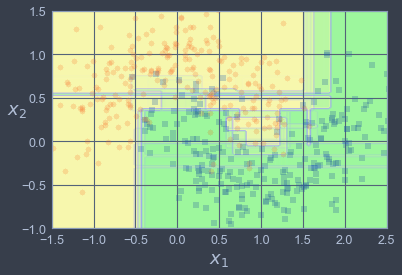

In [40]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# Out-of-bag error

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.


Out of bag error усредненная ошибка на 37% не используемых примерах.

<img src='pics/oobe.png'>

Слева то на чем тренируемся, справа то, на чем валидируемся.

# Важность признаков

### Упражнение
Как определить наиболее важные признаки?

## Замечание
- Чем выше признак, тем выше его важность.
- При оценке ошибки методом out-of-bag error можно сравнивать 2 различных набора признаков

Для того, чтобы оценить важность j-го параметра после тренировки, значения j-го параметра перемешиваются для всех записей тренировочного набора и out-of-bag-ошибка считается снова. Важность параметра оценивается путём усреднения по всем деревьям разности показателей out-of-bag-ошибок до и после перемешивания значений. При этом значения таких ошибок нормализуются на стандартное отклонение.

In [41]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/Users/alexandrbagdasarov/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


URLError: <urlopen error [Errno 60] Operation timed out>

In [ ]:
mnist["data"].shape

In [ ]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Extremely Randomized Trees

Случайным образом выбирать порог для разбиения в узлах деревьев (случайный набор порогов -> выбираем лучший порог)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

## Практические замечания

\+ RandomForest во многих задачах является сильным бейзлайном <br>
\+ хорошо работает на больших выборках (много признаков/много данных) <br>
\+ не сильно чувствителен к изменению параметров <br>
\+ не чувствителен к выбросам в данных из-за случайного сэмлирования <br>
\+ возвращает важности отдельных признаков <br>
\+ параллелизуется <br>
\+ не склонен к переобучению <br>

\- плохо работает на разреженных выборках <br>
\- занимает много памяти <br>
\- плохо интерпретируются <br>

# Boosting

* Обучить модель
* Посчитать ошибки
* Учесть ошибки и обучить новую модель
* Повторять некоторое количество раз

Нельзя обучать параллельно

# AdaBoost
Будем влиять на вес тренировочных примеров, участвующих в обучении.  
Из этих весов сможем рассчитывать вес модели

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
plot_decision_boundary(ada_clf, X, y)

Веса $w_i$ каждого обучающего примера $X_i$
$$X = \begin{bmatrix} 
a_1 & b_1 & c_1 & ... \\ 
a_2 & b_2 & c_2 & ... \\ 
a_3 & b_3 & c_3 & ... \\
... & ... & ... & ...
\end{bmatrix}, \space 
w = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 \\
... 
\end{bmatrix}$$

initially

$$w_i = \frac{1}{m}$$


$m$ - количество примеров в обучающей выборке (количество строк в $X$)

Обучаем модель и считаем ее error rate:


$$r = \frac{\sum\limits_{\hat{y} \neq y}{w}}{\sum w}$$

Чем больше ошибок, тем больше $r$

Считаем вес модели:

$$ \alpha = \eta log \frac{1-r}{r} $$

In [ ]:
def f(x):
    return np.log((1 - x) / x)

x = np.linspace(0, 10, 100)
y = f(x)
plt.plot(x, y)

Обновим веса:

$w$ не меняется, если предсказание верное   
$w \leftarrow w \cdot e^{\alpha} $, если предсказание ошибочное

Все веса нормализуются, делятся на $\sum w$

# Stacking, blending

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out - blending. 

In [ ]:
svm_clf.fit(X_in, y_in)
rnd_clf.fit(X_in, y_in)

svm_y = svm_clf.predict(X_out)
rnd_y = rnd_clf.predict(X_out)

In [ ]:
log_clf.fit(np.c_[svm_y, rnd_y], y_out)

In [ ]:
y_stack = log_clf.predict(np.c_[svm_clf.predict(X_test), rnd_clf.predict(X_test)])

In [ ]:
accuracy_score(y_test, y_stack)

In [ ]:
accuracy_score(y_test, rnd_clf.predict(X_test))

## Задача:
есть несколько базовых алгоритмов SVM, KNN, DecisionTree и несколько способов их композиции бэггинг, бустинг.
Для каких базовых алгоритмов какие способы композиции будут работать лучше? При необходимости нужно провести эксперименты.

## Дополнительные материалы:
[Bias Variance tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)


http://scott.fortmann-roe.com/docs/BiasVariance.html

[Заметка А.Дьяконова о случайных лесах](https://dyakonov.org/2016/11/14/случайный-лес-random-forest/)

https://www.kaggle.com/general/18793  

https://github.com/viisar/brew

[Важная презентация про случайный лес](http://docs.salford-systems.com/AdeleCutler.pdf)

[Статья А.Дьяконова про блендинг и стекинг](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)

## Фидбек

https://otus.ru/polls/1986/